<a href="https://colab.research.google.com/github/Anubhab17/M-D5030E---Bayesian-Data-Analysis-and-Probabilistic-Programming---24-25--colab_notebooks/blob/main/2_ProbProgramming_normal_normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import pymc as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
import numpy as np
import seaborn as sns
np.random.seed(44)


In [ ]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    'figure.figsize': [7,3],
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0,
})
sns.set(rc={'figure.figsize':(7,3)})

# Normal-normal models  in probabilistic programming


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on..


*   Chapter 2 of O. Martin, *Bayesian Analysis with Python, Second Edition*.

*  Notebook by G. Corani

# Normal - normal model


\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu})  && \text{prior uncertainty on } \mu\\
\sigma & \sim \text{HalfNormal} (\xi) &&  \text{prior uncertainty on } \sigma\\
\vec{y} & \sim N(\mu, \sigma) && \text{distribution of the data given } \mu \text{ and } \sigma \\
\end{align*}

* The observations $\vec{y}=\{y_1,y_2,y_n\}$ are assumed to be independent.


# Inference about the speed of light

* At the end of the 19th century  Newcomb carried out several experiments to determine the speed of light.

* He measured 66 times how much time it took for the light to travel a certain distance.

* A priori, he expected the travel time to be within (120,  360).

* A priori, he expect the noise measurement to yield an observations in an interval of +- 4 around the actual value.
     

In [ ]:
#Below  the  66 measurements.

data = np.array([248.28, 248.26, 248.33, 248.24, 248.34, 247.56, 248.27, 248.16,
                  248.4, 247.98, 248.29, 248.22, 248.24, 248.21, 248.25, 248.3,
                  248.23, 248.29, 248.31, 248.19, 248.24, 248.2, 248.36, 248.32,
                  248.36, 248.28, 248.25, 248.21, 248.28, 248.29, 248.37, 248.25,
                  248.28, 248.26, 248.3, 248.32, 248.36, 248.26, 248.3, 248.22,
                  248.36, 248.23, 248.27, 248.27, 248.28, 248.27, 248.31, 248.27,
                  248.26, 248.33, 248.26, 248.32, 248.32, 248.24, 248.39, 248.28,
                  248.24, 248.25, 248.32, 248.25, 248.29, 248.27, 248.28, 248.29,
                  248.16, 248.23])

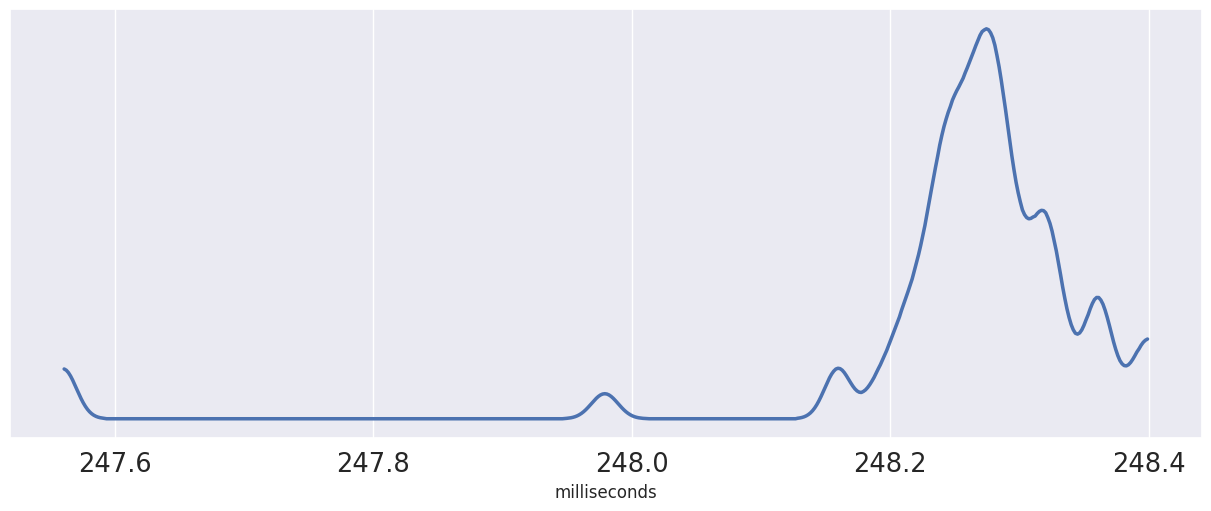

In [ ]:
# The data are almost  normally distributed, apart from some  low-values outliers  which are far from the mean.
#the density plot is called kde (kernel density estimation)
az.plot_kde(data, figsize=[12,5])
plt.yticks([])
plt.xlabel('milliseconds');

In [ ]:
# Implementation with  informative priors

with pm.Model() as normal_model:
    # Based on prior information, the mean travel time should be within  (120,  360).
    # This information can be represented by a normal distribution with mu = 240, sigma = 60.
    mu = pm.Normal('mu', 240, 60)

    # By using a  scale parameter of 3, the median  of the halfnormal is close to 2.,
    sigma = pm.HalfNormal('sigma', 3)


    #likelihood. The observation are stored in vector 'data'.
    #and assumed to be independent.
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data)

    trace_normal = pm.sample()

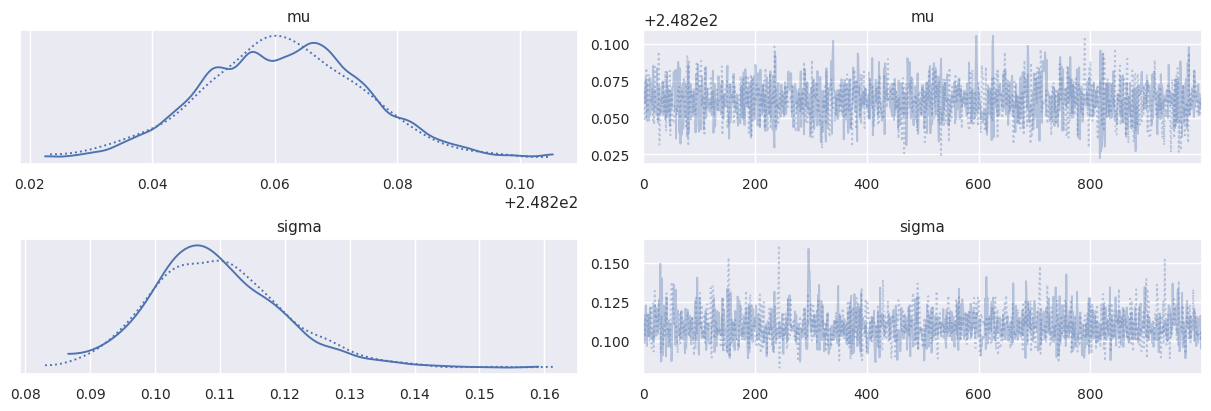

In [ ]:
# The  density plots of  both parameters are smooth and the chains are well-mixing.

with  normal_model:
    az.plot_trace(trace_normal);

# What if we change the prior?

In [ ]:
with pm.Model() as normal_model_2:

    #mu = pm.Normal('mu', 240, 60)
    #we assume to have  different prior information  about mu; larger mean and larger uncertainty.
    mu = pm.Normal('mu', 300, 100)

    #identical to the previous model
    sigma = pm.HalfNormal('sigma', 3)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data)

    trace_normal_2 = pm.sample(return_inferencedata=True)

In [ ]:
# The posterior is practically identical under the two different priors.
# This is  good: the data are strong enough to converge to the same posterior.
# The likelihood overwhelms the prior; the results are thus robust to the specification of the prior.


a = az.summary(trace_normal)
b = az.summary(trace_normal_2)
pd.concat([a,b])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,248.261,0.013,248.236,248.285,0.0,0.0,1638.0,1308.0,1.0
sigma,0.109,0.010,0.092,0.129,0.0,0.0,1773.0,1441.0,1.0
mu,248.262,0.014,248.236,248.288,0.0,0.0,1956.0,1268.0,1.0
sigma,0.110,0.010,0.091,0.129,0.0,0.0,2112.0,1310.0,1.0


# Predictions

# Point prediction

* How to make a prediction about the next measurement $y^{\text{new}}$?


* The simplest answer is to use the posterior mean (248.262, see previous slide). This is referred to as a **point prediction**. There is no quantification of the uncertainty.


#  Predictive distribution

* It is the probability distribution for the next observation, $y^{\text{new}}$
    * the distribution  accounts for the posterior about $\mu$ and  $\sigma$
    * it also accounts for the sampling uncertainty (noise of the data)
    * its expected value (i.e., the mean of the distribution) is the point prediction

    


# Computing the predictive distribution

* The trace contains e.g. 4000  samples, i.e., 4000 values of $\mu$ and $\sigma$; this is a numerical approximation of their posterior joint density.

* The $s$-th posterior sample contains a value for each parameter: $<\mu_s, \sigma_s >$.


# Computing the predictive distribution

* We compute a different prediction from  each sample $<\mu_s, \sigma_s >$ :

$$
\left[
\begin{array}{ll}
\mu_1 &   \sigma_1 \\
\mu_2 & \sigma_2 \\
\vdots & \vdots  \\
\mu_{4000}  & \sigma_{4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l}
y^{\text{new}}_{1} \\
y^{\text{new}}_{2} \\
\vdots \\
y^{\text{new}}_{4000} \\
\end{array}
\right]
$$

where:

$$y^{\text{new}}_{s} \; \sim \; N\left(\mu_s, \sigma_s\right)\;\; $$


* The  set of 4,000 values of $y_{\text{new}}$ approximates the  prediction distribution of a new measurement.

* The predictive distribution accounts for two types of uncertainties:
    * uncertainty in the value of the parameters $\mu$ and $\sigma$
    * sampling variability of the data: given a fixed value of $\mu$ and $\sigma$, there is random noise affecting the observation  ($y^{\text{new}}_{s} \; \sim \; N\left(\mu_s, \sigma_s\right)\;\;$)

# Building the predictive distribution

In [ ]:
#extract samples from the trace, merging samples from the different chains
post_samples = az.extract(trace_normal.posterior)

#vector of samples of each parameter
mu_post = post_samples.mu.values
sigma_post = post_samples.sigma.values

#vector containing the predictions.
y_new = np.zeros(len(mu_post))

#your code: compute a probabilistic prediction from each pair of  value <mu_s sigma_s>
#compute the 95% HDI of your prediction
#plot the kde of the sample values of y_new using az.plot_kde(y_new)
# solutions are at the end of the notebook

In [ ]:
# the posterior contains 4000 samples (4 chains * 1000 samples)
len(mu_post)

2000

In [ ]:
# The posterior prediction can be computed conveniently also within pymc.
# However for didactic reason implementing the  loop on the posterior samples
# helps understanding

with pm.Model() as normal_model_with_pred:
    #model as before
    mu = pm.Normal('mu', 240, 80)
    sigma = pm.HalfNormal('sigma', 3)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data)

    #prediction
    #for each sample value mu_s and sigma_s, a prediction is generated as N(mu_s, sigma_s).
    y_new = pm.Normal('y_new', mu=mu, sigma=sigma)

    trace_normal_with_pred = pm.sample(return_inferencedata=True)

In [ ]:
# using the 'var_names' argument we can select the variables shown in the summary
az.summary(trace_normal_with_pred, var_names='y_new', hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_new,248.259,0.109,248.056,248.473,0.002,0.002,2600.0,1364.0,1.0


# Posterior predictive checks


*  Even if the sampling has converged correctly, the model might be inadequate.

* The most fundamental way to check model fit is to display replicated datasets and compare them to the actual data.

* Hence, we  verify whether the predictive distribution resembles the distribution of the observations.

# Posterior predictive checks


*  Simulate replications of the data set using the posterior of the fitted model.
*  The original data set contains 66 observations.
*  The trace contains 4000 parameter samples.
*  We create 4000 simulated data sets, each of size 66.
*  We then visually check the distribution of each simulated data set vs the distribution of the observations.

# Posterior predictive checks

* The  `sample_posterior_predictive` automates the whole procedure.

* The returned ppc object contains 4000 data sets of size 66 (same size of the actual data set).



In [ ]:
with normal_model:
    # The returned ppc variable is a dictionary, with the keys being the name of the observed variable in our model and the values an array of shape (samples, size).
    # the function simulates a data set of size 66 for each  sample <mu_s ,sigma_s> in the trace
    ppc = pm.sample_posterior_predictive(trace_normal, model=normal_model)

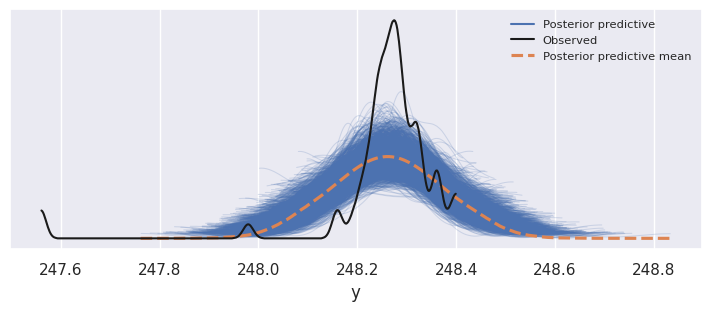

In [ ]:
# plot_ppc shows the overlay of density estimates of the actual data set (solid) and the simulated data sets.
# The average of the simulated densities is also shown.
# The simulated densities are too low in the center.
# That is becaude the  variance is  too large, having been inflated by outliers.
az.plot_ppc(ppc);

#  Robust models

* Outliers are too far from the mean  for the normal model.

* These points could be due to experimental errors. If we are sure that this is the case,  we could remove them from our dataset (leaving a record of the removal and the reasons why we did it).

* A more principled approach option is to adopt a likelihood which is *robust* to outliers.

# Robust models

* If the data set contains outliers, it is a good idea trying use a Student-$t$ distribution
rather than a normal distribution.


* The parameters of the distribution estimated using the t model are referred to as robust since they are  less influenced by outliers.

#  The normal distribution has light tails

* The normal distribution is  sensitive to outliers.


* The probability of finding a value falls rapidly as we move away from the mean; it is practically 0 when we are more than 3 standard deviation far from the mean.


* If the data contains observations which are even further from the mean, the normal distribution is not a good model. To adapt, the normal model should inflate much the variance.


* Probability of lying *outside* the interval $[ \mu - k \sigma, \mu + k \sigma]$:

| k | $P$ |
|:-:|:-:|
| 3 | 0.0026 |
| 4 | 0.00006 |

# Student's t distribution

<div style="text-align: center;">
 <img src='https://drive.google.com/uc?export=view&id=1ufQncebIiWZa4Jio61pEW57DzUZpi1Zo' width='400'>
</div>


* It is defined by a mean, a scale $\sigma$ (related to the spread of the distribution) and by $\nu$ ( *degrees of freedom*  or as *normality* coefficient).

*  $\nu$ controls how _heavy_ the tails of the distribution are.

    *  $\nu > 30$: the Student is practically equivalent to a Gaussian.

    * $\nu = 4$ is a common choice to have a robust model with heavy tails, which can model observations that are far away from the mean.

# Discussion

* The Student probability density decays as a polynomial function of the squared distance from the center, as opposed to an exponential function of the Gaussian.


* So there is more probability mass in the tail compared  with a Gaussian distribution: it has *heavy* tails, which allows modelling  outliers.


* For $\nu$  ≫ 5, the Student distribution rapidly approaches a Gaussian distribution and loses its robustness properties.

# Comparing the normal and the Student-t distribution


* Probability of lying *outside* the interval $(\mu - k \sigma, \mu + k \sigma)$:


| k |   Normal | Student ($\nu$=4) |
|:-:| :-: | :-: |    
| 3 | 0.002 | 0.04 |
| 4 | 0.00006 | 0.02 |
    
* The 99% interval is:

    * $\mu \pm 2.58 \sigma$ for the normal distribution;
   
    * $\mu \pm 4.61 \sigma$ for the Student-t distribution ($\nu$=4)

# Robust  model

\begin{align*}
\mu &\sim N(\mu', \sigma_{\mu}) && \text{prior on  } \mu\\
\sigma &\sim \text{Half-Normal}(\xi) && \text{prior on } \sigma \\
y & \sim StudentT (\mu, \sigma, \nu=4) && \text{robust model of the observations}
\end{align*}

In [ ]:
with pm.Model() as model_t:
    #the priors are the same as those of  the first variant
    mu_t    = pm.Normal('mu_t', 240, 80)
    sigma_t = pm.HalfNormal('sigma_t', sigma=3)

    #robust likelihood
    y       = pm.StudentT('y', mu=mu_t, sigma=sigma_t, nu=4, observed=data)

    #prediction for a new measurement
    #prediction = pm.StudentT('prediction', mu=mu_t, sd=sigma_t, nu=4)

    trace_t = pm.sample(return_inferencedata=True)

In [ ]:
# The estimate of mu is  identical between the model with normal and t likelihood,
# but the second has much lower  sigma than the normal model.
# The t- distribution gives less weight (being less surprised) to values away from the mean; it does not need inflating  the  variance.
#  This allows keeping higher the density around the bulk of the data, as it will be shown by the posterior predictive check.


with model_t:
    summary_t = az.summary(trace_t)
with normal_model:
    summary= az.summary(trace_normal)
pd.concat([summary, summary_t])[ ["mean","sd" ]]

,mean,sd
mu,248.261,0.013
sigma,0.109,0.010
mu_t,248.275,0.007
sigma_t,0.047,0.006


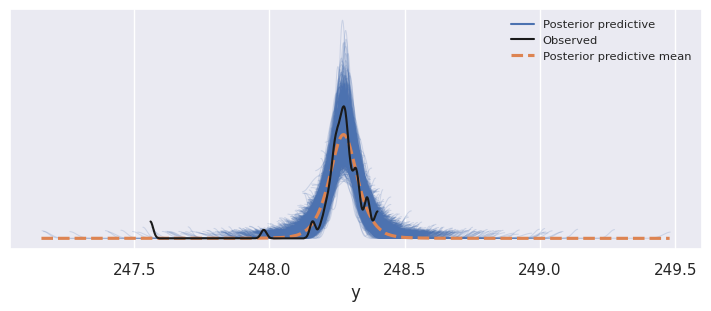

In [ ]:
with model_t:
    ppc_t = pm.sample_posterior_predictive(trace_t, model=model_t)
az.plot_ppc(ppc_t);

# Your turn - 1

* compute and compare  the predictive distribution for the next value $y^{new}$,  using the Gaussian and  the Student likelihood


* hint: use the function `t.rvs` to sample from a Student-t distribution, and remember to specify the same degrees of freedom of the likelihood function ($\nu$=4 in our case).

# Your turn - 2


* Using the speed of light data, calculate the mean and standard deviation with and without the _outliers_, compare those values ​​with those obtained with the gaussian and the robust model.


* Hint: consider outliers the observations which are more distant than 3.5 standard deviations from the mean.


* Is it beneficial to adopt a robust likelihood to analyze the data?

# Solutions

In [ ]:
# predictive distribution from the normal-normal model case

#extract samples from different chains
post_samples = az.extract(trace_normal.posterior)
mu_post      = post_samples.mu.values
sigma_post   = post_samples.sigma.values

#your code: compute a probabilistic prediction for the next observation
y_new = np.zeros(len(mu_post))

#we should use together  the values of sigma e mu referrring to the same sample
for i, current_mu in enumerate(mu_post):
        y_new[i] = np.random.normal (loc = mu_post[i], scale = sigma_post[i])

# apart from numerical differences, it is the same distribution returned
# by pymc in the model "normal_model_with_pred"
pd.DataFrame(y_new).describe(percentiles=[0.025, 0.975])

,0
count,2000.000000
mean,248.261076
std,0.107448
min,247.888655
2.5%,248.048603
50%,248.257238
97.5%,248.471709
max,248.627889


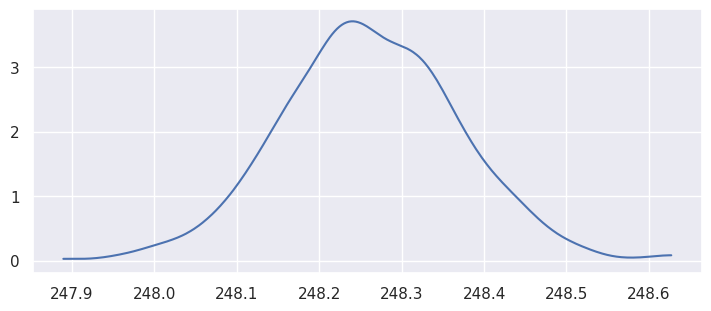

In [ ]:
az.plot_kde(y_new);

In [ ]:
# predictive distribution with the Student likelihood
from scipy.stats import t

#the  samples have been already extracted  in the previous cell
post_samples_t = az.extract(trace_t.posterior)
mu_post_t = post_samples_t.mu_t.values
sigma_post_t = post_samples_t.sigma_t.values

#your code: compute a probabilistic prediction for the next observation
y_new_t = np.zeros(len(mu_post_t))

#we should use together  the values of sigma e mu referrring to the same sample
for i, current_mu in enumerate(mu_post):
        y_new_t[i] = t.rvs (loc = mu_post_t[i], scale = sigma_post_t[i], df=4)

pd.DataFrame(y_new_t).describe(percentiles=[0.025, 0.975])

,0
count,2000.000000
mean,248.274656
std,0.067619
min,247.864286
2.5%,248.138621
50%,248.274374
97.5%,248.406563
max,248.866004


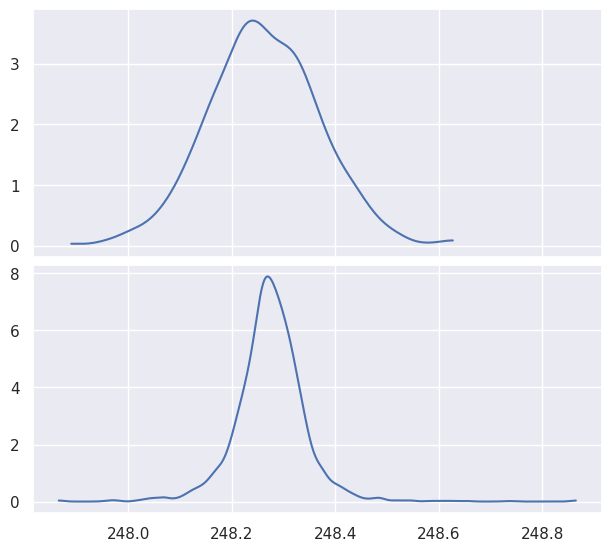

In [ ]:
#here we visually compare the predictive distribution of the model with Gaussian and  Studend likelihood.
#the t distribution has higher density around the mean; at the same time it has  longer tails.

#to make the visual comparison,  we set up two plots with a shared x-axis
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 5.4), sharex=True)
plt.subplot(2,1,1)
az.plot_kde(y_new);
plt.subplot(2,1,2)
az.plot_kde(y_new_t);

# Fitting the model with Gaussian likelihood after removing outliers


In [ ]:
#Below  the  66 measurements.

data = np.array([248.28, 248.26, 248.33, 248.24, 248.34, 247.56, 248.27, 248.16,
                  248.4, 247.98, 248.29, 248.22, 248.24, 248.21, 248.25, 248.3,
                  248.23, 248.29, 248.31, 248.19, 248.24, 248.2, 248.36, 248.32,
                  248.36, 248.28, 248.25, 248.21, 248.28, 248.29, 248.37, 248.25,
                  248.28, 248.26, 248.3, 248.32, 248.36, 248.26, 248.3, 248.22,
                  248.36, 248.23, 248.27, 248.27, 248.28, 248.27, 248.31, 248.27,
                  248.26, 248.33, 248.26, 248.32, 248.32, 248.24, 248.39, 248.28,
                  248.24, 248.25, 248.32, 248.25, 248.29, 248.27, 248.28, 248.29,
                  248.16, 248.23])

xbar= np.mean(data)
s = np.std(data)

#the criterion for detecting outliers is a heuristic one.
#here we consider as outliers observations which are more than 3.5 std far from the mean.

# we remove observations lower than xbar - 3.5 sigma
data2 = data [data > xbar - 3.5 * s]

# we remove observations larger than xbar +3.5 sigma
data2 = data2 [data2 < xbar + 3.5 * s]

#one observation has been removed
print(len(data))
print(len(data2))

66
65


In [ ]:
with pm.Model() as normal_model_no_outliers:
    #prior for the location of mu
    # Based on prior information,  mu should lie within the interval (120,  360).
    # This corresponds to a normal distribution with mu = 240, sigma = 60
    mu = pm.Normal('mu', 240, 60)

    #Based on prior information, a plausible value for the standard deviation of the noise is 2.
    # This is roughly the median value of the halfnormal distribution with scale set to 3.
    sigma = pm.HalfNormal('sigma', sigma=3)


    #likelihood. Each observation is a sample from N(mu, sigma).
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data2)

    trace_normal_no_outliers = pm.sample( return_inferencedata= True )

In [ ]:
# the sigma of the Gaussian model decreases much once outliers are removed.
b = az.summary(trace_normal)
c = az.summary(trace_normal_no_outliers)
pd.concat([b,c])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,248.261,0.013,248.236,248.285,0.0,0.0,1638.0,1308.0,1.0
sigma,0.109,0.010,0.092,0.129,0.0,0.0,1773.0,1441.0,1.0
mu,248.273,0.008,248.258,248.287,0.0,0.0,2150.0,1293.0,1.0
sigma,0.064,0.006,0.053,0.074,0.0,0.0,2388.0,1485.0,1.0


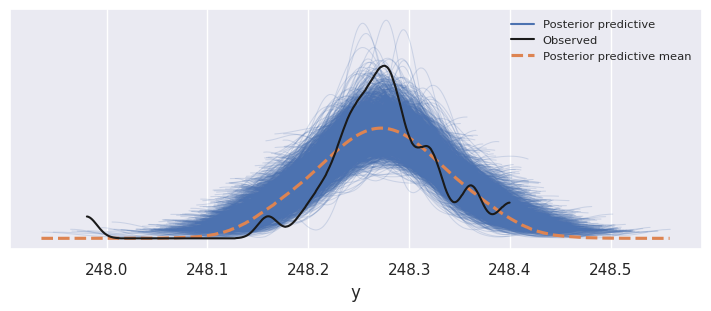

In [ ]:

#the posterior predictive is improved compared to the Gaussian model fitted on the original data.
# Anyway, this requires the heuristic work of deciding which observation is an outlier.
# Moreover, this shows how sensitive can be the estimation of the normal model to outliers (we only removed one datum out of 66)
with normal_model_no_outliers:
    ppc_t = pm.sample_posterior_predictive(trace_normal_no_outliers)

az.plot_ppc(ppc_t);